In [1]:
import numpy as np
from dynamic_coding_analysis.analysis_pipeline import get_data
from dynamic_coding_analysis.analysis_pipeline import process_spikes as spk
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from tqdm import trange

C:\Users\ilow1\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# define sessions
base = 'G:/My Drive/Giocomo Lab/RandomForage/'
data_folder = base + 'aggregate_data/'
save_folder = base + 'Dynamic MEC Coding Project/fig1_images_final/'
supp_save_folder = base + 'Dynamic MEC Coding Project/fig1_images_supp/'

''' run analysis on sessions with >10 MEC neurons '''
mice = ['Pisa', # cue poor
        'Seattle', 'Toronto', # cue rich
        'Degu'] # two tracks

sessions = [['0430_1'], # Pisa
            ['1010_1'], # Seattle
            ['1113_1'], # Tortonto
            ['0721']] # Degu

In [3]:
# make a dict to hold data
data = {}
for session, m in zip(sessions, mice):
    data[m] = {}
    for s in session:
        data[m][s] = {}

In [4]:
'''
Assign colors based on track type
see: https://personal.sron.nl/~pault/#sec:qualitative Fig. 4
cue poor : green
cue rich : pink
double track : green/pink
'''
cp_color = [17/255, 119/255, 51/255, 1]
cr_color = [204/255, 102/255, 119/255, 1]

colors = [cp_color, cr_color]

In [5]:
# load the data
from pathlib import Path

for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        d['Y'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_FRtensor.npy')
        d['B'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_spikes.npy')
        d['A'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_behavior.npy')  
        
        # filter sessions with deleted AP/ML cells
        d['cells'] = np.load(data_folder + 'gap_corrected/{}_{}_MEC_cellIDs.npy'.format(m, s))
        filt_file = data_folder + 'gap_corrected/{}_{}_MEC_idx.npy'.format(m, s)
        if Path(filt_file).exists():
            print(m + '_' + s + ' corrected for mistargeting')
            cell_idx = np.load(filt_file)
            d['cells'] = d['cells'][cell_idx]
            d['Y'] = d['Y'][:, :, cell_idx]
            d['B'] = d['B'][:, cell_idx]

In [6]:
for m, session in zip(mice, sessions):
    for s in session:
        spike_file = data_folder + m + '_' + s + '_spikeInfo.npy'
        if Path(spike_file).exists():
            sp = np.load(data_folder + m + '_' + s + '_spikeInfo.npy').item()
            d = data[m][s]
            d['sp'] = sp
        else:
            print('{} {} no spike file!'.format(m, s))

In [7]:
''' get coordinates for all recorded units and filter out non-MEC units '''
hist = np.load(data_folder + '_histology.npy').item()
# get coordinates for all cells
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        sp = d['sp']
        cells_unfilt = sp['cids'][sp['cgs']==2] # unsorted
        cells = d['cells'] # sorted by depth
        MEC_idx = np.isin(cells_unfilt, cells) # unsorted

        # get probe coordinates
        coords = hist[m][s]['histology']
        tip = coords[0][:-1]
        entry = coords[1]

        # get distance from tip
        depth = sp['spike_depth'].copy() # unsorted
        MEC_depth = np.sort(depth[MEC_idx]) # sort by depth

        # convert to brain coordinates
        cell_coords = spk.get_coordinates(tip, entry, MEC_depth)
        d['cell_coords'] = cell_coords

In [8]:
''' load cue rich/poor separately for double-track mice '''
mice_2track = ['Degu']
sessions_split = [['0721cr', '0721cp']]

In [9]:
# add to data dict
for m, session in zip(mice_2track, sessions_split):
    for s in session:
        data[m][s] = {}

In [10]:
for m, session in zip(mice_2track, sessions_split):
    for i, s in enumerate(session):
        d = data[m][s]
        d['Y'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_FRtensor.npy')
        d['B'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_spikes.npy')
        d['A'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_behavior.npy')  
        
        # cells is the same across cr/cp
        s_trunc = s[:4]
        d['cells'] = data[m][s_trunc]['cells']
        d['cell_coords'] = data[m][s_trunc]['cell_coords']

In [11]:
''' plot example insertions relative to MEC boundaries '''
example_mice = ['Pisa', 'Toronto', 'Seattle', 'Degu', 'Degu']
example_sessions = ['0430_1', '1113_1', '1010_1', '0721cr', '0721cp']
example_cells = [[362, 317, 717], [220, 160, 75], [529, 301, 590, 68], [259, 275, 370], [259, 275, 370]]

In [12]:
''' fig. 1k '''
from mpl_toolkits.mplot3d import Axes3D

# f = plt.figure(figsize=(0.7, 2.2))
# ax = f.add_subplot(111, projection='3d')

example_coords = []
for i, m in enumerate(example_mice):
    # set params
    s = example_sessions[i]
    cell_IDs = example_cells[i]
    if m == 'Degu':
        coords = hist[m][s[:4]]['histology']
    else:
        coords = hist[m][s]['histology']        
    
    # get cell coordinates
    d = data[m][s]
    cells = d['cells']
    cell_coords = d['cell_coords']
    idx = []
    for j, cell_ID in enumerate(cell_IDs):
        idx.append((np.where(cells==cell_ID)[0][0]).astype(int))
    idx = np.asarray(idx)
    example_coords.append(cell_coords[idx, :])

In [13]:
# calculate cosine similarity across trials
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

for m, s in zip(example_mice, example_sessions):
    d = data[m][s]
    Y = d['Y'].copy()
    Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
    sim_vec = np.abs(pdist(Y_unwrapped, 'correlation')-1)
    sim = squareform(sim_vec)
    d['similarity'] = sim

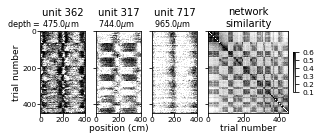

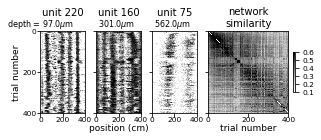

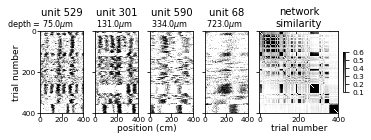

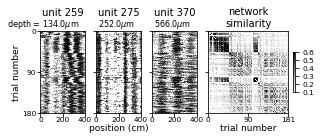

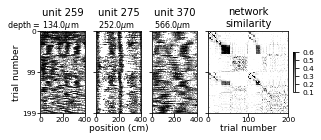

In [14]:
''' fig. 1m-o '''
for j, m in enumerate(example_mice):
    if m == 'Seattle':
        gs  = gridspec.GridSpec(1, 12, wspace=0.7)
        f = plt.figure(figsize=(5.7, 1.5))
    else:
        gs  = gridspec.GridSpec(1, 10, wspace=0.7)
        f = plt.figure(figsize=(4.8, 1.5))
    
    s = example_sessions[j]
    cell_IDs = example_cells[j]
    
    # load data
    d = data[m][s]
    A = d['A']
    B = d['B']
    cells = d['cells']
    
    # plot example rasters
    ax_start = 0
    for i, cell_ID in enumerate(cell_IDs):
        ax_end = ax_start+2
        sdx = B[:, np.where(cells==cell_ID)[0][0]].astype(bool)
        ax0 = plt.subplot(gs[ax_start:ax_end])

        # plot it
        if m in mice_2track:
            ax0.scatter(A[:, 0][sdx], A[:, 2][sdx], color='k', lw=0, s=0.4, alpha=.3)
        else:
            ax0.scatter(A[:, 0][sdx], A[:, 2][sdx], color='k', lw=0, s=0.2, alpha=.3)
        ax0.set_xlim([0, 400])
        ylim_ax = [0, np.max(A[:, 2])]
        ax0.set_ylim(ylim_ax[::-1])
        if m in mice_2track:
            trial_num = np.max(A[:, 2])
            ax0.set_yticks([0, np.round(trial_num//2, 2), np.round(trial_num, 2)])
        else:
            ax0.set_yticks([0, 200, 400])
        
        ax0.set_title('unit {}'.format(cell_ID), fontsize=10, pad=16)
        if i==0:
            ax0.set_ylabel('trial number', fontsize=9, labelpad=1)
        elif i==1:
            if m == 'Seattle':
                ax0.set_xlabel('position (cm)', fontsize=9, labelpad=1, 
                               horizontalalignment='left', x=0.5)
            else:
                ax0.set_xlabel('position (cm)', fontsize=9, labelpad=1)
            ax0.tick_params(labelleft=False)
        else:
            ax0.tick_params(labelleft=False)
            
        if m == 'Degu':
            if i==0:
                ax0.text(-300, -10, 'depth = {}$\mu$m'.format(np.round(example_coords[j][i, -1])), fontsize=8)
            else:
                ax0.text(15, -10, '{}$\mu$m'.format(np.round(example_coords[j][i, -1])), fontsize=8)
        else:
            if i==0:
                ax0.text(-300, -25, 'depth = {}$\mu$m'.format(np.round(example_coords[j][i, -1])), fontsize=8)
            else:
                ax0.text(15, -25, '{}$\mu$m'.format(np.round(example_coords[j][i, -1])), fontsize=8)

        ax0.set_xticks(np.arange(0, 450, 200))
        ax0.tick_params(which='major', labelsize=7.5, pad=0.5)
        ax_start = ax_end
    
    # plot Euclidean similarity score
    sim = d['similarity']
    ax1 = plt.subplot(gs[ax_end:])
    im = ax1.imshow(sim, clim=[0.1, 0.6], aspect='auto', cmap='Greys')

    if m in mice_2track:
        trial_num = sim.shape[0]
        ax1.set_xticks([0, np.round(trial_num//2, 2), np.round(trial_num, 2)])
        ax1.set_yticks([0, np.round(trial_num//2, 2), np.round(trial_num, 2)])
    else:
        ax1.set_xticks([0, 200, 400])
        ax1.set_yticks([0, 200, 400])    
    ax1.set_xlabel('trial number', fontsize=9, labelpad=1)
    ax1.tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
    ax1.set_title('network\nsimilarity', fontsize=10, pad=5)
    cbar = f.colorbar(im, shrink=0.5)
    cbar.ax.tick_params(labelsize=7.5)

    f.savefig(save_folder + m + '_' + s + '_rasters_similarity.png', dpi=400, bbox_inches='tight')
    plt.show()

In [ ]:
for m, s in zip(example_mice, example_sessions):
    d = data[m][s]
    print('{}, session {}, n cells = {}'.format(m, s, d['cells'].shape[0]))